In [1]:
from nltk.corpus import stopwords
import re
import spacy
import pandas as pd

stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


city_newsletter_re=re.compile(r'([A-Za-z\s]+)?\/?([A-Z\s]+)?(,?\s[A-za-z]+.+\s)?\(Reuters\)')
html_re=re.compile(r'<[^>]+>|&amp;|&lt;|&gt;|&nbsp;')
links_re=re.compile(r'http[s]?:\/\/\S+')
date_re=re.compile(r'(\b(January|February|March|April|May|June|July|August|September|October|November|December)\b\s\d{1,2},\s\d{4})',re.IGNORECASE)
username_re=re.compile(r'@\w+')
punctuation_re=re.compile(r'[^\w\s]')
image_reference=re.compile(r'(Featured|Photo\sby|Image)[\w\/\s]+',re.IGNORECASE)

def data_lemmatizing(text): 
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc]
)

def preprocess_data_fake_news(text):
    text=date_re.sub('',text)
    text=image_reference.sub('',text)
    text=html_re.sub('',text)
    text=username_re.sub('',text)
    text=links_re.sub('',text)
    text=punctuation_re.sub('',text)
    return " ".join(w for w in text.split() if w.lower() not in stop_words)

def preprocess_data_true_news(text):
    text=city_newsletter_re.sub('',text, count=1)
    text=punctuation_re.sub('',text)
    return " ".join(w for w in text.split() if w.lower() not in stop_words)

def lower_text(text):
    return text.lower()

D:\github\AI-examples\AI_examples\.venv\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
from tqdm import tqdm

tqdm.pandas()


df_fake= pd.read_csv("data/Fake.csv")
df_true= pd.read_csv("data/True.csv")

df_true.isna().sum()
df_true.drop_duplicates(inplace=True)
df_true.reset_index(drop=True, inplace=True)

df_fake["label"] = 0
df_true["label"] = 1

In [3]:
df_fake['cleaned_text'] = df_fake['text'].progress_apply(preprocess_data_fake_news)
df_fake['clean_text']=df_fake['cleaned_text'].progress_apply(data_lemmatizing)
df_fake['clean_text_lower']=df_fake['clean_text'].progress_apply(lower_text)

100%|██████████| 23481/23481 [00:00<00:00, 617927.07it/s]


In [4]:
df_true['cleaned_text'] = df_true['text'].progress_apply(preprocess_data_true_news)
df_true['clean_text'] = df_true['cleaned_text'].progress_apply(data_lemmatizing)
df_true['clean_text_lower']=df_true['clean_text'].progress_apply(lower_text)

100%|██████████| 21211/21211 [00:00<00:00, 509798.13it/s]


In [5]:
frames=[df_true,df_fake]
df=pd.concat(frames)
df.reset_index(drop=True,inplace=True)
df.drop_duplicates() #eliminam duplicatele
df = df.dropna(subset=["clean_text"]) #elimin valorile care au coloana clean_text nula
df = df.sample(frac = 1)#dam suffle la date
df.to_csv("data/fake_and_real_news_final_.csv")

In [6]:
df.sample(3)

,title,text,subject,date,label,cleaned_text,clean_text,clean_text_lower
35013,BEST EVER CROOKED HILLARY Collection Of Lies A...,Hillary Clinton has had a loooong career at ly...,politics,"May 28, 2016",0,Hillary Clinton loooong career lying twisting ...,Hillary Clinton loooong career lie twist thing...,hillary clinton loooong career lie twist thing...
15899,British government extends Northern Ireland ta...,BELFAST (Reuters) - The British government on ...,worldnews,"October 30, 2017",1,British government Monday extended 24 hours de...,british government Monday extend 24 hour deadl...,british government monday extend 24 hour deadl...
42412,OBAMA WARNS: Crackdown On Terrorism In U.S. Wo...,Never mind that Iran continues to violate Obam...,left-news,"Dec 21, 2015",0,Never mind Iran continues violate Obama lopsid...,never mind Iran continue violate Obama lopside...,never mind iran continue violate obama lopside...


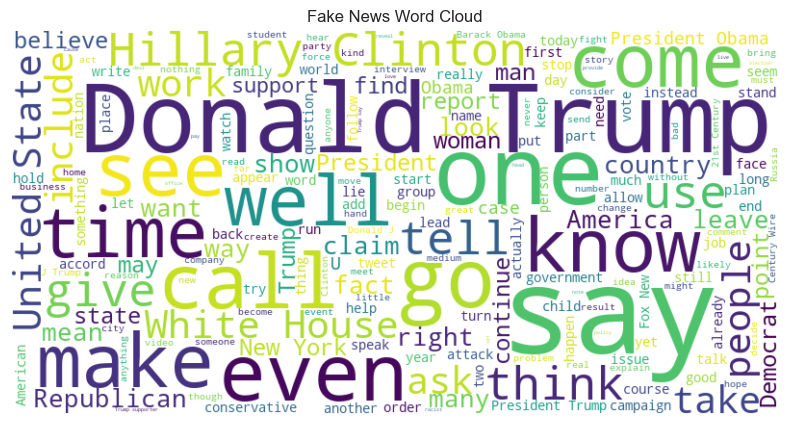

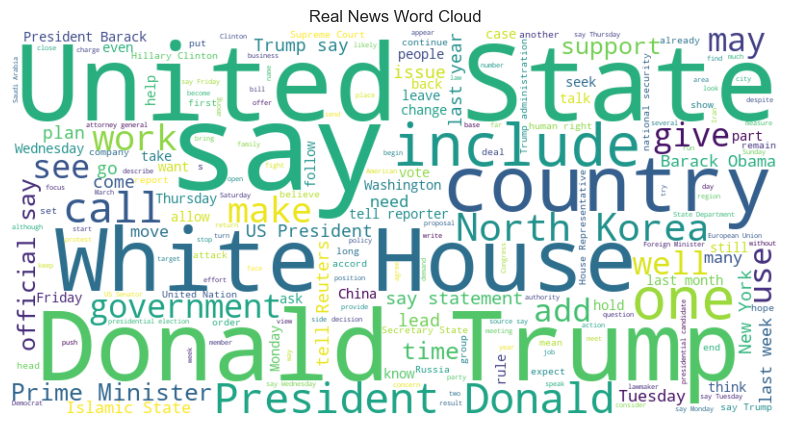

In [7]:
fake_news=df[df['label']==0]
real_news=df[df['label']==1]
text_fake_news = ' '.join(fake_news['clean_text'].astype(str).tolist())
text_real_news = ' '.join(real_news['clean_text'].astype(str).tolist())
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_fake_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("./diagrams/wc_fn.png")
plt.title("Fake News Word Cloud")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_real_news)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Real News Word Cloud")
plt.savefig("./diagrams/wc_rn.png")
plt.show()